In [ ]:
import pandas as pd
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()
r['load']('data_ml.RData') #RData로드
data_ml = pandas2ri.ri2py(r['data_ml'])

In [3]:
import pyreadr # RData 파일을 읽기 위한 라이브러리
# 2) RData 안에 들어있는 객체(데이터프레임들) 이름을 확인
# RData는 여러 객체를 담을 수 있어서, dict(사전)처럼 반환됨
result = pyreadr.read_r('data_ml.RData')
print(result.keys())
# 3-a) 객체 이름을 알고 있을 때(예: 'data_ml')
# 3-b) 혹시 정확한 이름을 모를 때: 첫 번째 객체를 꺼내기
# data_ml = next(iter(result.values()))
data_ml = result['data_ml']
# 4) CSV로 저장
# to_csv 인수 설명:
# - 'data_ml.csv' : 저장할 파일명/경로
# - index=False : DataFrame의 행 인덱스(0,1,2,...)를 파일에 쓰지 않음
# - encoding='utf-8' : (선택) 한글 깨짐 방지. 기본은 utf-8이라 보통 생략 가능
# - na_rep='': (선택) 결측값(NaN)을 빈칸으로 저장하고 싶을 때
data_ml.to_csv('data_ml.csv', index=False)
print("CSV저장완료:", data_ml.shape)

odict_keys(['data_ml'])
CSV저장완료: (283380, 99)


In [7]:
import pandas as pd
data_raw = pd.read_csv('data_ml.csv')
idx_data = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
# 날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_data]
# 날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6,0:6] # 데이터프레임 예시 출력

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
0,13,2006-12-31,0.25,0.33,0.27,0.22
1,13,2007-01-31,0.25,0.32,0.28,0.22
2,13,2007-02-28,0.26,0.30,0.30,0.22
3,17,2015-03-31,0.73,0.64,0.70,0.40
4,17,2015-04-30,0.72,0.62,0.66,0.40
5,17,2015-05-31,0.71,0.63,0.64,0.40


Text(0, 0.5, 'nb_assets')

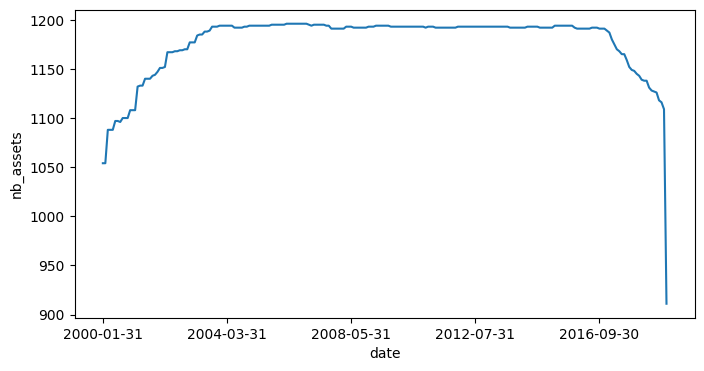

In [9]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4))
#각 날짜별 자산 수 개수 세기
plt.ylabel('nb_assets')

In [13]:
features=list(data_ml.iloc[:,3:95].columns)
#특성의 열 이름을 저장해놓는다(하드코딩되어 있으니 주의할 것).
features_short =["Div_YLd", "Eps", "Mkt_Cap_12M_Usd","Mom_11M_Usd","Ocf","Pb", "Vol1Y_Usd"]

Text(0, 0.5, 'count')

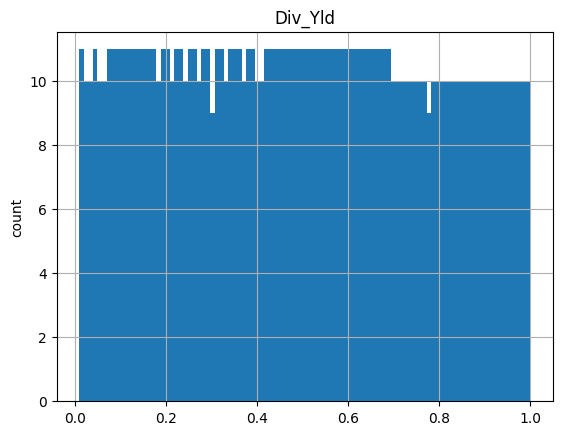

In [15]:
col_feat_Div_Yld = data_ml.columns.get_loc('Div_Yld')
# 특성 Div_Yld 열의 위치 찾기
is_custom_date=data_ml['date']=='2000-02-29'
# 필터링할 부울 인덱스 생성
data_ml[is_custom_date].iloc[:,[col_feat_Div_Yld]].hist(bins=100)
# 히스토그램 사용하기
plt.ylabel('count')

In [21]:
df_median=[] # 임시 데이터프레임을 위한 빈 리스트 생성
df=[]        # 임시 데이터프레임을 위한 빈 리스트 생성
import numpy as np
df_median=data_ml[['date','R1M_Usd','R12M_Usd']].groupby(
    ['date']).median() # 각 날짜별로 2개의 레이블에 대한 중간값 계산
df_median.rename(
    columns={"R1M_Usd": "R1M_Usd_median",
             "R12M_Usd": "R12M_Usd_median"},inplace=True)
df = pd.merge(data_ml,df_median,how='left', on=['date'])
# 데이터프레임 합치기
data_ml['R1M_Usd_C'] = np.where( # 범주형 레이블 생성
    df['R1M_Usd'] > df['R1M_Usd_median'],1.0,0.0)
data_ml['R12M_Usd_C'] = np.where( # 범주형 레이블 생성
    df['R12M_Usd'] > df['R12M_Usd_median'],1.0,0.0)

/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_90251/1399870463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where( # 범주형 레이블 생성
/var/folders/6_/gfrk7lt15d79q76hpjbm56ph0000gn/T/ipykernel_90251/1399870463.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where( # 범주형 레이블 생성


In [22]:
separation_date = "2014-01-15"
idx_train=data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test=data_ml.index[(data_ml['date']<separation_date)].tolist()

In [23]:
stock_ids_short=[]
stock_days=[]
stock_ids=data_ml['stock_id'].unique() # 모든 stock_ids의 리스트
stock_days=data_ml[['date','stock_id']].groupby(
    ['stock_id']).count().reset_index() # 각 주식별 데이터 포인트 개수 세기
stock_ids_short=stock_days.loc[
    stock_days['date']==(stock_days['date'].max())]
# 데이터가 전부 있는 주식을 
stock_ids_short=stock_ids_short['stock_id'].unique()
# 리스트로 변환
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)
returns=data_ml[is_stock_ids_short].pivot(
    index='date',columns='stock_id',values='R1M_Usd' # 수익률 행렬
)